In [4]:
import Modules.SQcircuit_extensions as sq_ext
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl

importlib.reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

# Single circuit

This notebook studies the circuit proposed by KIT. It's lumped element model is:
<img src='Other/Single circuit 4 nodes CC coupled to ground.jpg' width='500'>


## Define the circuit

In [5]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

# Initialize loop(s)
loop = sq.Loop(0.0)  # "Value" corresponds to phiExt / phi0 threading the loop (can change later)
elements = {
    # Without ground node
    (0, 3): [sq.Inductor (Lr,       'nH')],
    (0, 1): [sq.Capacitor(C,        'fF')],
    (0, 2): [sq.Capacitor(C,        'fF')],
    (3, 1): [sq.Inductor (Lq/2 - Δ, 'nH',  loops=[loop])],
    (1, 2): [sq.Junction (EJ,       'GHz', loops=[loop]), sq.Capacitor(CJ+Csh, 'fF')],
    (2, 3): [sq.Inductor (Lq/2 + Δ, 'nH',  loops=[loop])],

    # With ground node
    # (0, 1): [sq.Capacitor(Cg,       'fF')],
    # (1, 4): [sq.Inductor (Lr,       'nH')],
    # (1, 2): [sq.Capacitor(C,        'fF')],
    # (1, 3): [sq.Capacitor(C,        'fF')],
    # (4, 2): [sq.Inductor (Lq/2 - Δ, 'nH',  loops=[loop])],
    # (2, 3): [sq.Junction (EJ,       'GHz', loops=[loop]), sq.Capacitor(CJ+Csh, 'fF')],
    # (3, 4): [sq.Inductor (Lq/2 + Δ, 'nH',  loops=[loop])],
}

# Create the circuits
circuit = sq.Circuit(elements)
circuit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
circuit.S

array([[ 1.72026745e+01,  5.05170698e+01, -4.83005796e-01],
       [ 1.82026745e+01,  4.95170698e+01,  5.16994204e-01],
       [ 3.45304159e+08,  3.07829540e+01,  7.99662964e-03]])

# Equivalent circuits

In [5]:
# loop_eq = sq.Loop(0.0)
# equiv_elements = {
#     (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor ( 1/(  1/(l/Lq) -  1/(l/Δ)  ), 'nH')],
#     (1, 2): [sq.Inductor (l/Δ, 'nH')],
#     (0, 2): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor ( 1/(  1/(l/(Lq+4*Lr)) -  1/(l/Δ)  ), 'nH',  loops=[loop_eq]), sq.Junction (EJ, 'GHz', loops=[loop_eq])],
# }
# circ_equiv = sq.Circuit(equiv_elements )
# circ_equiv.description()

LinAlgError: Last 2 dimensions of the array must be square

In [9]:
resonator_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [36]:
loop_fluxonium = sq.Loop(0.0)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
    # (0, 1): [sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium], cap=sq.Capacitor(C/2 + Csh + CJ, 'fF'))],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Analyze the convergence of truncation numbers vs external flux

[1, 3, 8] [-8.25373714 -1.04544983  1.29631342  6.16160256  8.50472763] 0.008673447921796194


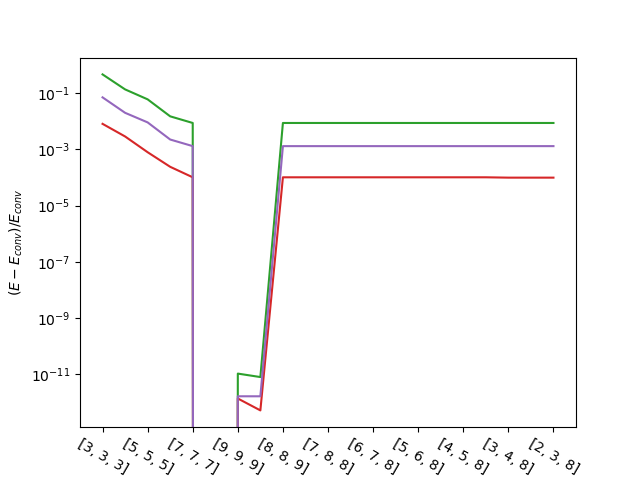

[[1, 3, 8], [1, 3, 8], [1, 3, 8]]


In [6]:
# external flux for sweeping over
phi = np.linspace(-1,1,100)
n_eig=5

# calculate truncation numbers for initial, mid and final value of external flux.
trunc_vs_phi = []
loop.set_flux(phi[0])
circuit = sq_ext.truncation_convergence(circuit, n_eig, plot=True, threshold = 1e-2)
trunc_vs_phi.append(circuit.m)

loop.set_flux(phi[len(phi)//2])
circuit = sq_ext.truncation_convergence(circuit, n_eig, trunc_nums=circuit.m, threshold = 1e-2)
trunc_vs_phi.append(circuit.m)

loop.set_flux(phi[-1])
circuit = sq_ext.truncation_convergence(circuit, n_eig, trunc_nums=circuit.m, threshold = 1e-2)
trunc_vs_phi.append(circuit.m)

print(trunc_vs_phi)

## Resonator spectrum

In [37]:
L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
w_r = 1/np.sqrt(L_r*C_r) / 2 / np.pi / 1e9
E_harm = w_r * np.arange(0,8)
E_harm

array([ 0.        ,  7.2083882 , 14.41677639, 21.62516459, 28.83355279,
       36.04194098, 43.25032918, 50.45871738])

## Potential energy fluxonium


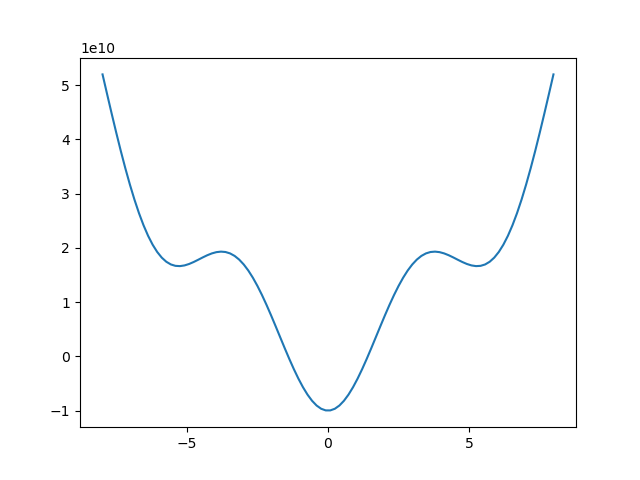

In [31]:
Φ_q = np.linspace(-8,8,100)
Φ_ext = 0
L_q = l / (Lq + 4*Lr) * 1e-9
E_J = EJ * 1e9
V = 0.5 * 1/L_q * (Φ_q*2*np.pi)**2 - E_J * np.cos(Φ_q-Φ_ext)

fig, ax = plt.subplots()
ax.plot(Φ_q,V )
ax.set_xticks([-5,0,5])
fig.show()

## Eigenstates fluxonium

In [38]:
loop_fluxonium.set_flux(0.5)
_, _ = fluxonium.diag(5)
phi1 = np.pi*np.linspace(-1.5,1.5,500)
# creat the grid list
grid = [phi1]

# the ground state
state0 = fluxonium.eig_phase_coord(k=0, grid=grid)
plt.plot(phi1, np.abs(state0)**2, '#ff7f32')

NameError: name 'loop_fluxonium' is not defined

## Spectrum vs external flux

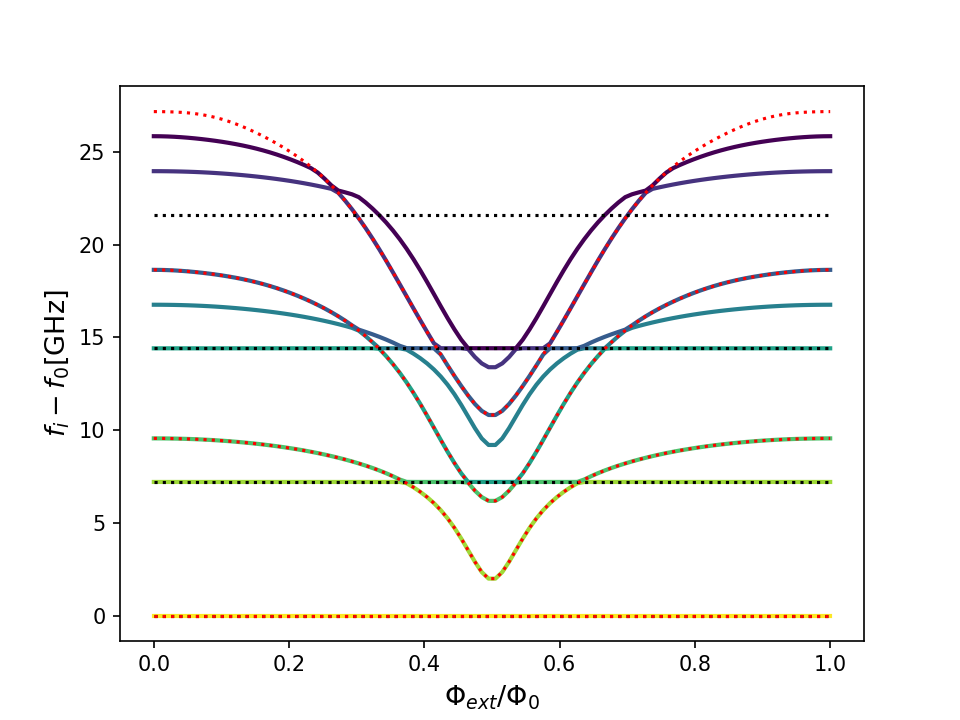

In [12]:
circuit.set_trunc_nums([1, 3, 10])
fluxonium.set_trunc_nums([10])

# spectrum of the circuit
phi = np.linspace(0,1,100)
n_eig=8
spec = np.zeros((n_eig, len(phi)))
E_qubit = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop_fluxonium.set_flux(phi[i])
    loop.set_flux(phi[i])
    # diagonalize the circuit
    spec[:, i] = circuit.diag(n_eig)[0]
    E_qubit[:, i] = fluxonium.diag(n_eig)[0]

fig, ax = plt.subplots(dpi=150)
for i in range(n_eig):
    ax.plot(phi, spec[i,:]- spec[0,:], color=eig_colors[i], linewidth=2)
for i in range(n_eig//2):
    ax.plot([phi[0],phi[-1]], [E_harm[i],E_harm[i]], ':k' )
    ax.plot(phi, E_qubit[i,:]- E_qubit[0,:], color='r', linestyle = ':')

ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
ax.set_ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
fig.show()

## Eigenstates in phase base

In [10]:
# creat the phase grid
phi1 = 0
phi2 = np.linspace(-0.005, 0.005, 100)
phi3 = np.linspace(-0.5, 0.5  , 100)
grid = [phi1, phi2, phi3]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = circuit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(circuit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(circuit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(circuit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(circuit.eig_phase_coord(3, grid=grid))

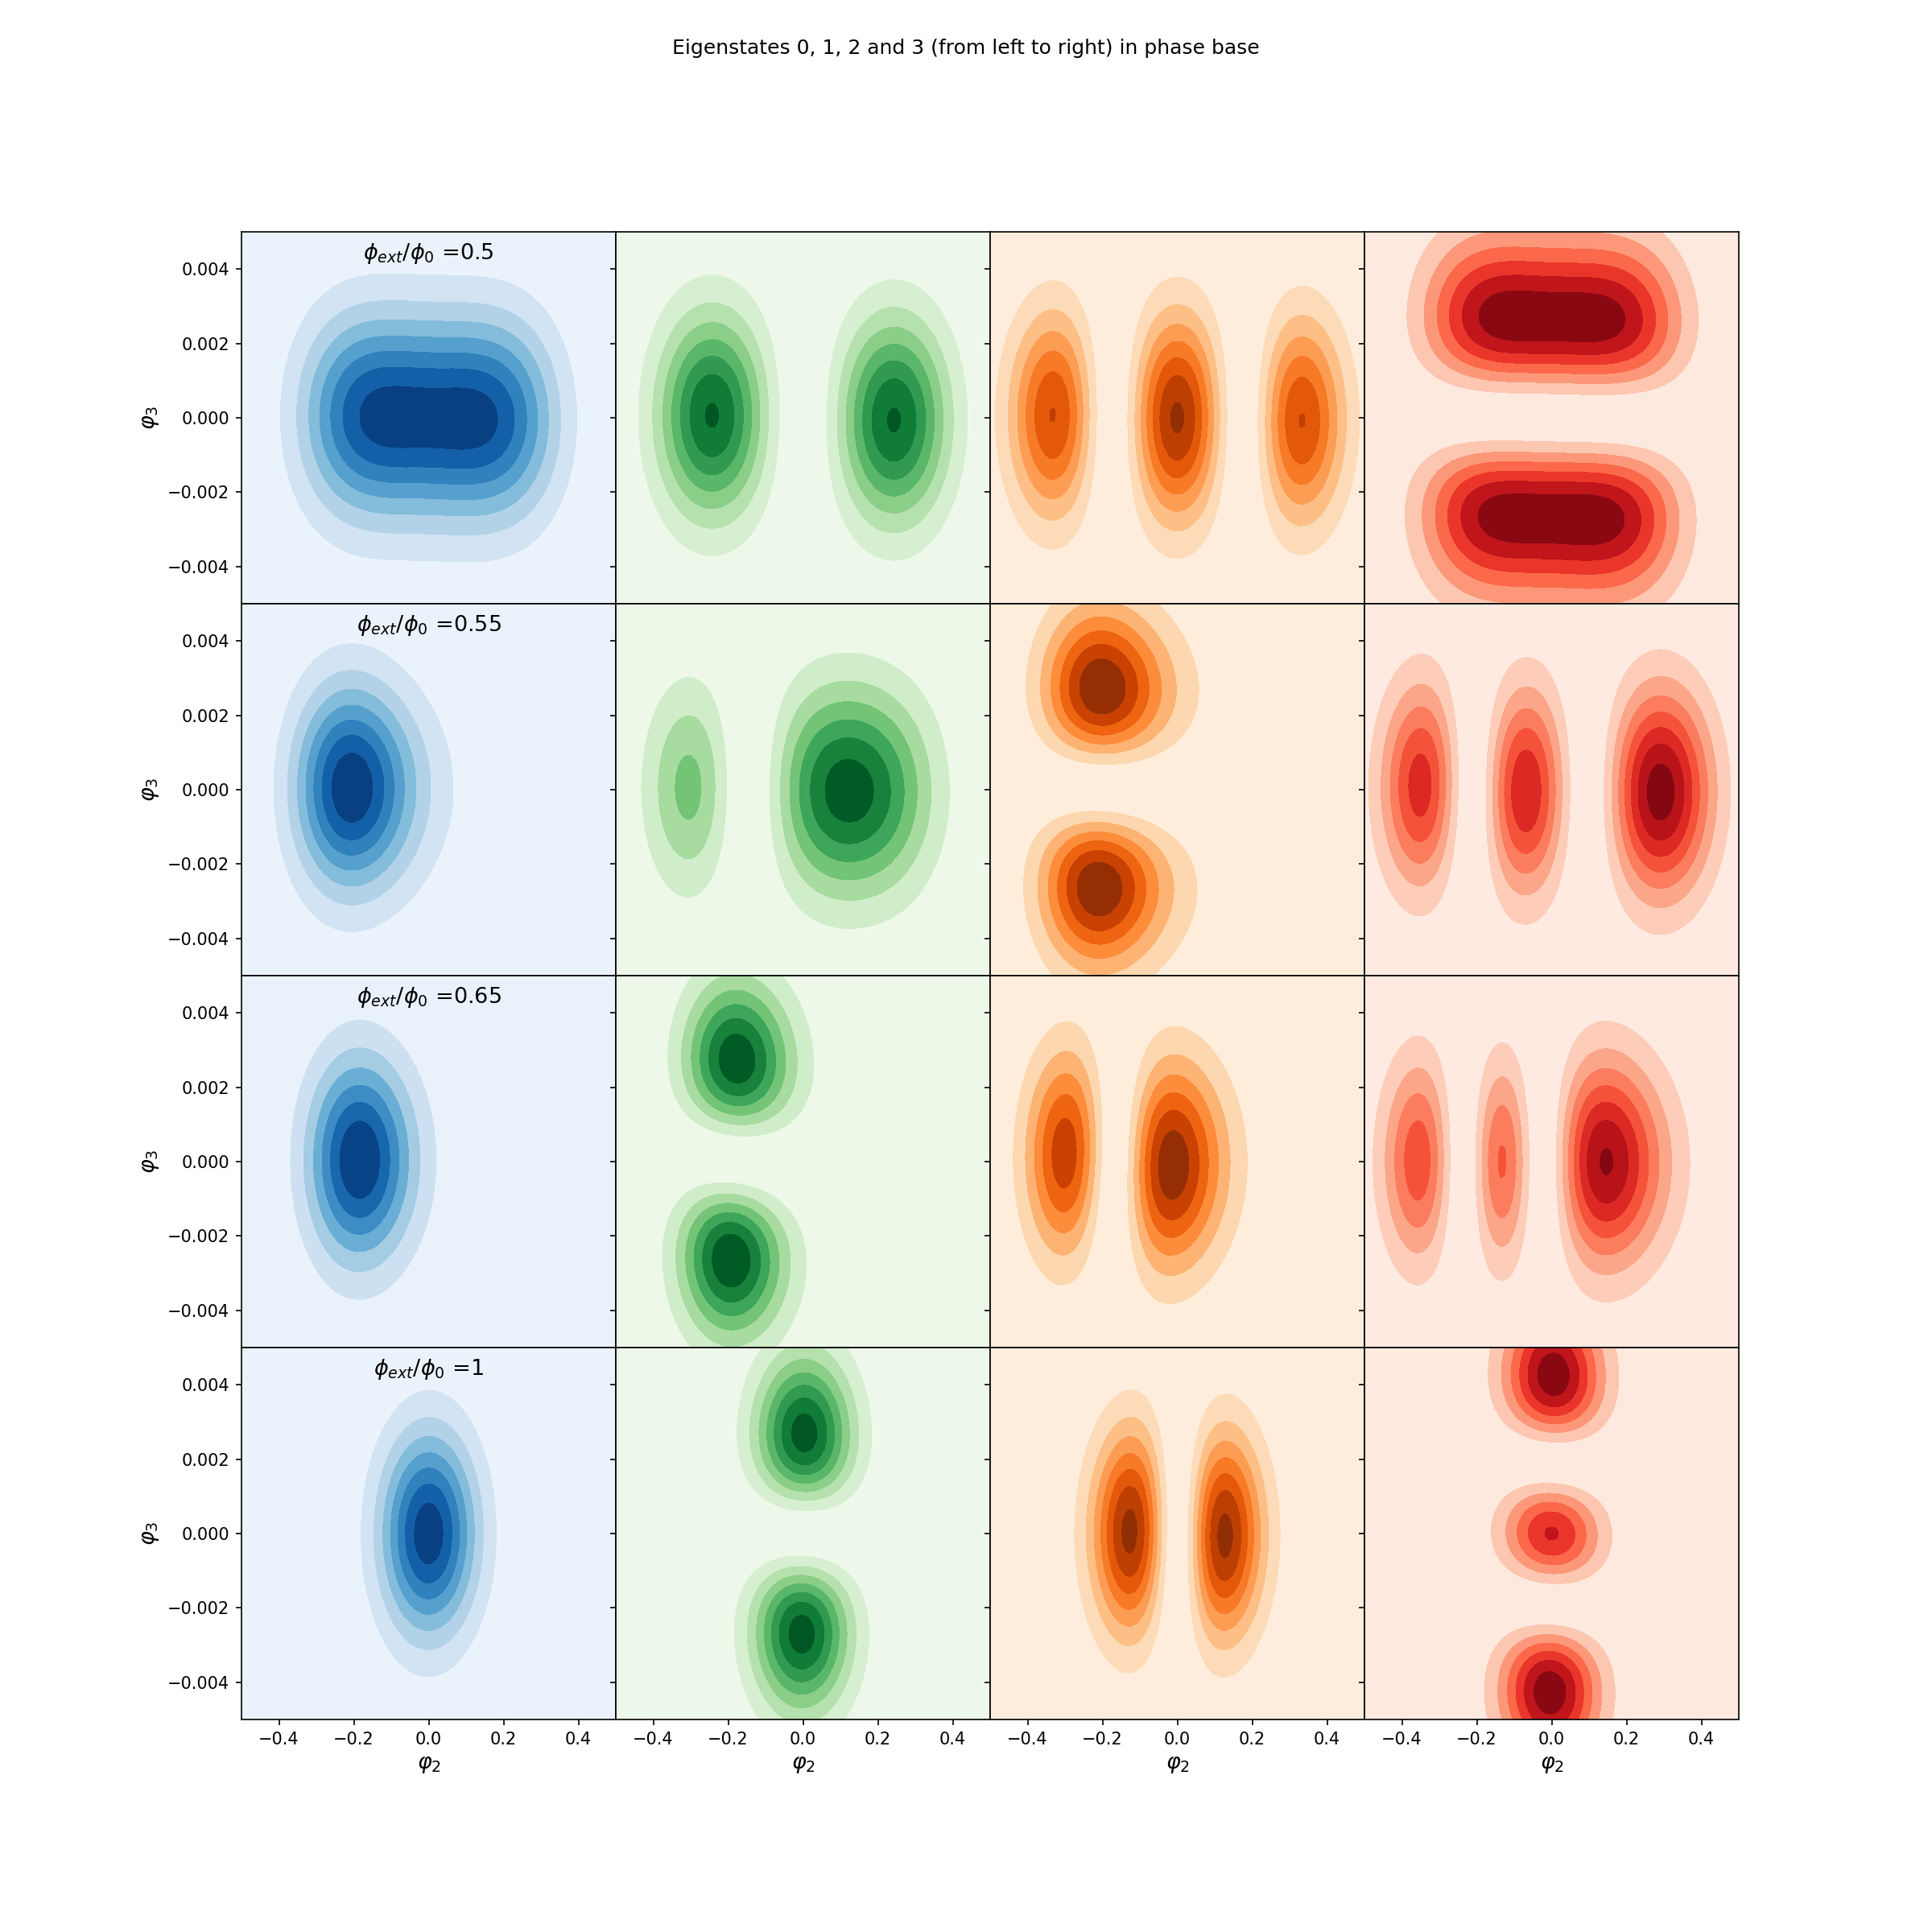

In [74]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues", )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Greens" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Oranges")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()